### Multi-resolution image registration by homography transformation using matrix manifold optimization

In [0]:


from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian, resize
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from torch.autograd import Function


import torch.nn as nn
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
cuda:0


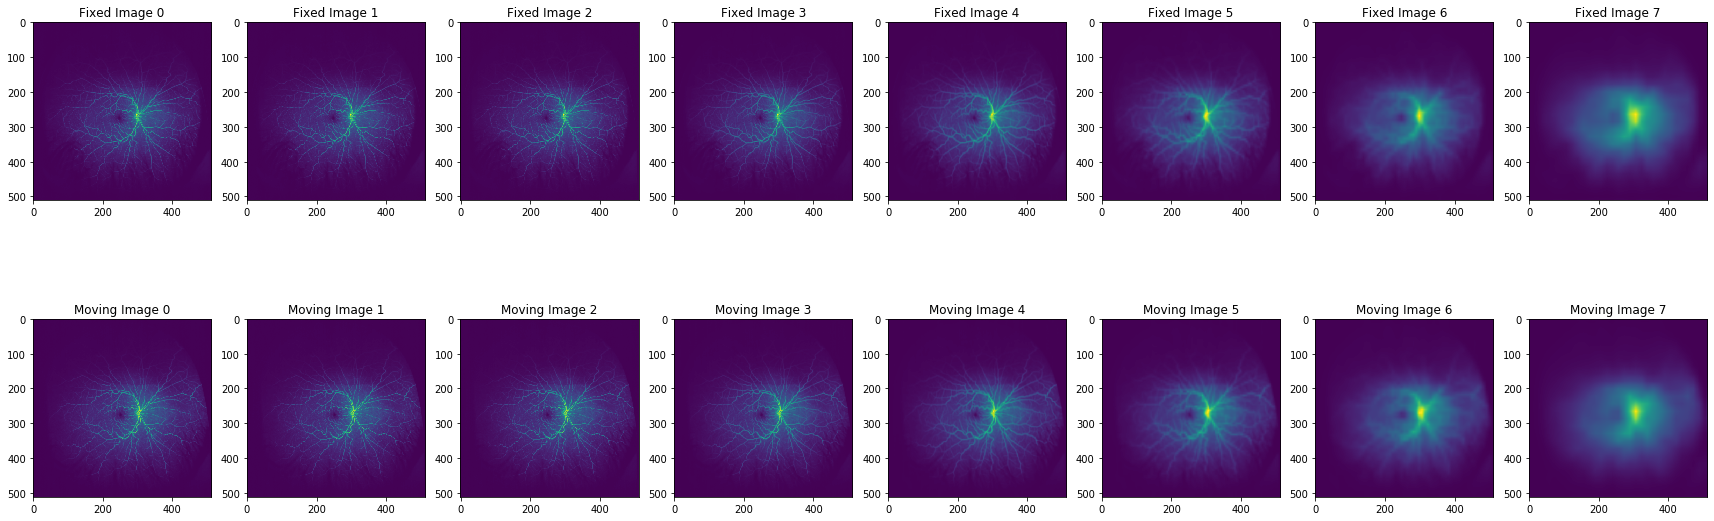

In [0]:
I = io.imread("/content/drive/My Drive/617_cmput/a2/fixed.bmp").astype(np.float32) # fixed image
J = io.imread("/content/drive/My Drive/617_cmput/a2/moving.bmp").astype(np.float32) # fixed image

pyramid_I = [None]*8
pyramid_J = [None]*8
pyramid_I_t = tuple(pyramid_gaussian(I, downscale=2, multichannel=False))
pyramid_J_t = tuple(pyramid_gaussian(J, downscale=2, multichannel=False))

%matplotlib inline
fig=plt.figure()
fig.set_size_inches(30, 10)

input_size = 512

for i in range(0,8):
  pyramid_I[i] = resize(pyramid_I_t[i], (input_size, input_size))
  pyramid_J[i] = resize(pyramid_J_t[i], (input_size, input_size))
  fig.add_subplot(2,8,i+1)
  plt.imshow(pyramid_I[i])
  plt.title("Fixed Image %d"%i)
  fig.add_subplot(2,8,i+9)
  plt.imshow(pyramid_J[i])         
  plt.title("Moving Image %d"%i)

In [0]:
def PerspectiveTransform(I, H, xv, yv):
  
  # apply homography
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I.view(1,1,height,width),torch.stack([xvt,yvt],2).unsqueeze(0)).squeeze()
  return J

def MatrixExp(B, u):
        
  C = torch.sum(B*u,0)
  A = torch.eye(3).to(device)
  H = A + C
  for i in torch.arange(2,10):
    A = torch.mm(A/i,C)
    H = H + A
  return H

In [0]:
H1 = 61504
H2 = 4096
H3 = 512
H4 = 16

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer1_2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(H1, H2)
        self.fc2 = nn.Linear(H2, H3)
        self.fc3 = nn.Linear(H3, H4)
        self.fc4 = nn.Linear(H4, 1)
        
    def forward(self, x, y):
      out1 = self.layer1_1(x)
      out2 = self.layer1_2(y)
      out = self.layer2(out1+out2)
      out = self.layer3(out)
      out = out.reshape(out.size(0), -1)
      #out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      out = self.fc3(out)
      out = self.fc4(out)
      
      return out




In [0]:
learning_rate = 1e-5
learning_rate_model = 1e-8
weight_decay= 1e-5

model = Net().cuda()
optimizer_model = torch.optim.Adam(model.parameters(), lr=learning_rate_model, weight_decay=weight_decay,amsgrad=True)
plot_loss = []

# perspective transform basis matrices

B = torch.zeros(8,3,3).to(device)
B[0,0,2] = 1.0
B[1,1,2] = 1.0
B[2,0,1] = 1.0
B[3,1,0] = 1.0
B[4,0,0], B[4,1,1] = 1.0, -1.0
B[5,1,1], B[5,2,2] = -1.0, 1.0
B[6,2,0] = 1.0
B[7,2,1] = 1.0

# multi-resolution registration
# Consider 8 levels in the pyramid for this example
nItr = torch.tensor([800,600,600,500,400,300,300,300])
#nItr = torch.tensor([20,20,20,20,20,20,20,20])

torch.autograd.set_detect_anomaly(False)

# create variables and optimization at each level
v = nn.Parameter(torch.zeros(8,1,1).to(device), requires_grad=True)
optimizer = torch.optim.Adam([v], lr=learning_rate, amsgrad=True)
#optimizer = torch.optim.Adam([v], lr=learning_rate)

for level in torch.arange(7,-1,-1): # start at level 7
  I = pyramid_I[level].astype(np.float32)
  I_random = np.random.permutation(I)
  I_random = torch.tensor(I_random).to(device)

  J = pyramid_J[level].astype(np.float32)

  if level>0:
    I = pyramid_I[level].astype(np.float32)
    I = torch.tensor(I).to(device)

    J = pyramid_J[level].astype(np.float32)
    J = torch.tensor(J).to(device)

  else:    
    I = torch.tensor(gaussian(pyramid_I[level].astype(np.float32),2.0)).to(device)
    J = torch.tensor(gaussian(pyramid_J[level].astype(np.float32),2.0)).to(device)
  
  height,width = I.shape

  # choose a set of pixel locations on the template image that are most informative
  tval = 0.9*threshold_otsu(I.cpu().numpy()) # reduce Otsu threshold value a bit to cover slightly wider areas
  ind = (I.data>tval).view([height*width])
  important_ind = torch.nonzero(ind).squeeze()

  tval_random = 0.9*threshold_otsu(I_random.cpu().numpy()) # reduce Otsu threshold value a bit to cover slightly wider areas
  rand_ind = (I_random.data>tval).view([height*width])
  random_ind = torch.nonzero(rand_ind).squeeze()

  # generate grid only once at each level
  yv, xv = torch.meshgrid([torch.arange(0,height).float().to(device), torch.arange(0,width).float().to(device)])
  # map coordinates to [-1,1]x[-1,1] so that grid_sample works properly
  yv = 2.0*yv/(height-1) - 1.0
  xv = 2.0*xv/(width-1) - 1.0

  for itr in range(nItr[level]):
    J_w = PerspectiveTransform(J, MatrixExp(B,v), xv, yv)

    x_sample = torch.unsqueeze(J_w, 0)        #.view([height*width])[important_ind]
    y_sample = torch.unsqueeze(I, 0)          #.view([height*width])[important_ind]
    y_random_sample = torch.unsqueeze(I_random, 0)        #.view([height*width])[important_ind]

    x_sample = torch.unsqueeze(x_sample, 0)
    y_sample = torch.unsqueeze(y_sample, 0)
    y_random_sample = torch.unsqueeze(y_random_sample, 0)

    #x_sample = torch.tensor(x_sample.to(device).type(torch.FloatTensor), requires_grad = True)    
    #y_sample = Variable(y_sample.to(device).type(torch.FloatTensor), requires_grad = True)    
    #y_shuffle = Variable(y_random_sample.type(torch.FloatTensor), requires_grad = True)    
    
    pred_xy = model(x_sample,y_sample)  # joint distribution
    pred_x_y = model(x_sample, y_random_sample) # marginal distribution

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret # Maximize lower bound
    #plot_loss.append(loss.data.numpy())
    loss.backward(retain_graph=True)
    #print("MINE: ",  loss.data)
    optimizer_model.step()
    optimizer.step()

    #loss = F.mse_loss(J_w.view([height*width])[important_ind], I.view([height*width])[important_ind])
    #loss = F.mse_loss(J_w, I)
    #loss.backward()
    if itr%100==0:
      #loss = F.mse_loss(J_w, I)
      H = MatrixExp(B,v).data
      J_w = PerspectiveTransform(J, H, xv, yv)
      print("Pyramid level:",level.item(),"Iteration:",itr,"MI loss:",loss.item(), "MSE loss: ", F.mse_loss(J_w, I).item())
      #print(v)
    model.zero_grad()
    optimizer.zero_grad()

  H = MatrixExp(B,v).detach()
  J_w = PerspectiveTransform(J, H, xv, yv)
  #loss = F.mse_loss(J_w, I)
  print("Pyramid level:",level.item(),"Iteration:",itr+1,"MI loss:",loss.item(), "MSE loss: ", F.mse_loss(J_w, I).item())

# final transformation
I = torch.tensor(pyramid_I[0].astype(np.float32)).to(device) # without Gaussian
J = torch.tensor(pyramid_J[0].astype(np.float32)).to(device) # without Gaussian
J_w = PerspectiveTransform(J, H, xv, yv)
ret
D = J - I
D_w = J_w - I
print(" ")
print("MSE before registration:",torch.mean(D**2).cpu().item())
print("MSE after registration:",torch.mean(D_w**2).cpu().item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Pyramid level: 7 Iteration: 0 MI loss: -0.13530191779136658 MSE loss:  6.054719924926758
Pyramid level: 7 Iteration: 100 MI loss: -0.7696267366409302 MSE loss:  5.733097076416016
Pyramid level: 7 Iteration: 200 MI loss: -1.4063533544540405 MSE loss:  5.554133892059326
Pyramid level: 7 Iteration: 300 MI loss: -2.0420055389404297 MSE loss:  5.326363563537598
Pyramid level: 6 Iteration: 0 MI loss: -2.1891398429870605 MSE loss:  6.626677513122559
Pyramid level: 6 Iteration: 100 MI loss: -3.0713412761688232 MSE loss:  6.953027248382568
Pyramid level: 6 Iteration: 200 MI loss: -3.856527805328369 MSE loss:  7.071434020996094
Pyramid level: 6 Iteration: 300 MI loss: -4.603083610534668 MSE loss:  7.035538673400879
Pyramid level: 5 Iteration: 0 MI loss: -4.092041492462158 MSE loss:  11.453531265258789
Pyramid level: 5 Iteration: 100 MI loss: -5.084128379821777 MSE loss:  8.818703651428223
Pyramid level: 5 Iteration: 200 MI loss: -5.994582176208496 MSE loss:  8.132055282592773
Pyramid level: 5 It

MI before registration: 0.9955604608630195
MI after registration: 1.1027035806688865
MSE before registration: 105.93154907226562
MSE after registration: 60.0797233581543


Text(0.5, 1.0, 'Difference image after registration')

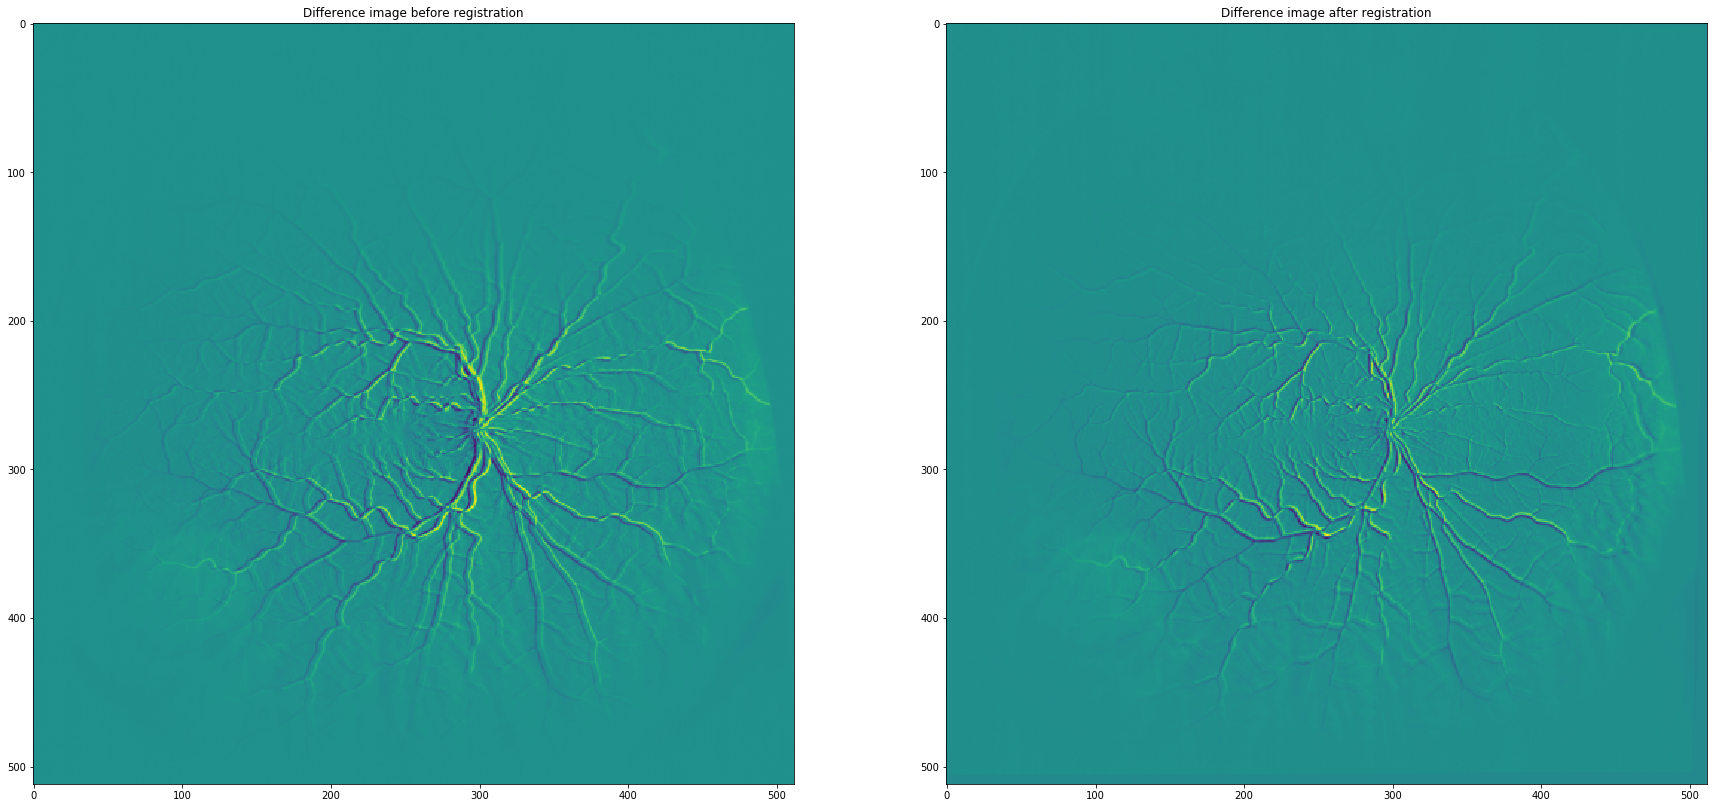

In [0]:
def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

print("MI before registration:", histogram_mutual_information(pyramid_I[0],pyramid_J[0]))
print("MI after registration:", histogram_mutual_information(pyramid_I[0],J_w.cpu().numpy()))
print("MSE before registration:",torch.mean(D**2).cpu().item())
print("MSE after registration:",torch.mean(D_w**2).cpu().item())
#print(H)
%matplotlib inline
fig=plt.figure(figsize=(30,30))
fig.add_subplot(1,2,1)
plt.imshow(D.cpu().data)
plt.title("Difference image before registration")
fig.add_subplot(1,2,2)
plt.imshow(D_w.cpu().data)         
plt.title("Difference image after registration")


'''
Reference:
https://github.com/sungyubkim/MINE-Mutual-Information-Neural-Estimation-
https://github.com/search?q=mutual+information+estimation
'''